# 20230511 - Determining region level clustering 

1. Calculate lobm scargle on padded regions with known assignments
2. Total power per joint within region (proboscis, locomotion, idle, etc)
* Bar graph for total power
* Threshold for things that aren’t actually moving

3. Threshold each node (Slack)
4. All by all distance claculation (frame by frame)
* Normalized but thresholded
* Unnormalized but thresholded
* Unnormalized no threshold

5. Generate distance matrix
* Distance matrix with dendrogram

In [ ]:
import os
import h5py
import numpy as np
from scipy.io import loadmat
import logging
import pickle

# Setting up proper logging
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)
logger.addHandler(logging.StreamHandler())

wavelets_file = "/Genomics/ayroleslab2/scott/git/lts-manuscript/analysis/notebooks/data/wavelet_results.pickle"
wavelet_results = pickle.load(open(wavelets_file, "rb"))

In [ ]:
average_total_power_per_node = {}

# Iterate over each behavior
for behavior, behavior_wavelets in wavelet_results.items():
    logger.info(f"Aggregating wavelets for behavior {behavior}")
    wlets = np.concatenate(list(behavior_wavelets.values()), axis=0)
    wlets = np.abs(wlets)# ** 2  # Power
    # wlets[wlets < 1e7] = 0 # Thresholding
    
    total_power_per_node = []

    # Calculate power per node for each set of wavelets
    for wavelet in behavior_wavelets.values():
        power = np.abs(wavelet) ** 2

        # Sum over the frames axis (0th dimension, as power shape is (frames, nodes*freqs))
        total_power = np.sum(power, axis=0)
        
        # Reshape to separate node and frequency dimensions (assuming number of nodes is 24 and freqs is 25)
        total_power = total_power.reshape(-1, 24, 25)

        # Sum over the frequency axis to get total power per node
        total_power_per_node.append(np.sum(total_power, axis=2))

    # Average over all wavelet sets for the behavior
    average_total_power = np.mean(total_power_per_node, axis=0)

    average_total_power_per_node[behavior] = average_total_power

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Node names
node_names = ['eyeL_x', 'eyeL_y', 'eyeR_x', 'eyeR_y', 'abdomen_x', 'abdomen_y', 'forelegL_x', 'forelegL_y', 'forelegR_x', 'forelegR_y', 'midlegL_x',
              'midlegL_y', 'midlegR_x', 'midlegR_y', 'hindlegL_x', 'hindlegL_y', 'hindlegR_x', 'hindlegR_y', 'wingL_x', 'wingL_y', 'wingR_x', 'wingR_y', 'proboscis_x', 'proboscis_y']

# Prepare data for seaborn
data = []
for behavior, powers in average_total_power_per_node.items():
    for node_name, power in zip(node_names, powers.flatten()):
        data.append([behavior, node_name, power])

df = pd.DataFrame(data, columns=["Behavior", "Node", "Average Power"])

# Plot
plt.figure(figsize=(15, 8))
sns.barplot(data=df, x="Node", y="Average Power", hue="Behavior")
plt.title('Average Power per Behavior per Node')
plt.ylabel('Average Power')
plt.xlabel('Node')
plt.xticks(rotation=90)
plt.tight_layout()
plt.yscale('log')
plt.ylim(1e-2)
plt.savefig('figures/power_per_behavior_per_node.jpg')
plt.show()

In [ ]:
import seaborn as sns
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage

# concatenate all wavelets from all behaviors and keep track of behavior assignments
all_wavelets = []
behavior_labels = []
for behavior, behavior_wavelets in wavelet_results.items():
    for wavelet in behavior_wavelets.values():
        all_wavelets.append(wavelet)
        behavior_labels.append(behavior)
        
behavior_labels = []
for behavior, behavior_wavelets in wavelet_results.items():
    for wavelet in behavior_wavelets.values():
        behavior_labels += [behavior] * wavelet.shape[0]

# stack all wavelets into a 2D array (frames x frequencies)
all_wavelets = np.vstack(all_wavelets)

In [ ]:
import seaborn as sns
import matplotlib.patches as mpatches
from scipy.spatial.distance import pdist, squareform
from scipy.stats import entropy
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt

def normalize_power_spectra(power_spectra):
    power_spectra_reshaped = power_spectra.reshape(-1, 24, 25)
    node_means = power_spectra_reshaped.mean(axis=-1)
    node_stds = power_spectra_reshaped.std(axis=-1)

    # Create a mask for nodes with non-zero standard deviation to avoid division by zero
    non_zero_std_mask = node_stds != 0

    # Z-score normalize each node
    for i in range(power_spectra_reshaped.shape[0]):
        power_spectra_reshaped[i, non_zero_std_mask[i]] = (power_spectra_reshaped[i, non_zero_std_mask[i]] - node_means[i, non_zero_std_mask[i]][:, None]) / node_stds[i, non_zero_std_mask[i]][:, None]

    # Reshape back to original shape
    power_spectra = power_spectra_reshaped.reshape(-1, 600)
    return power_spectra, node_means, node_stds

def threshold_power_spectra(power_spectra, threshold):
    # Create a boolean mask for nodes with total power less than threshold
    power_spectra_reshaped = power_spectra.reshape(-1, 24, 25)
    node_sums = power_spectra_reshaped.sum(axis=-1)
    mask = node_sums < threshold

    # Use broadcasting to apply the mask across the last dimension (the 25 elements in each node)
    for i in range(power_spectra_reshaped.shape[0]):
        power_spectra_reshaped[i][mask[i]] = 0

    power_spectra = power_spectra_reshaped.reshape(-1, 600)
    return power_spectra

def compute_distance_matrix(power_spectra, dist_method):
    if dist_method in ['euclidean', 'cityblock']:
        dist_matrix = pd.DataFrame(squareform(pdist(power_spectra, metric=dist_method)), columns=behavior_labels, index=behavior_labels)
    elif dist_method in ['kullback-leibler', 'jensen-shannon']:
        # Convert data to probability distributions before calculating divergences
        power_spectra_prob = power_spectra / power_spectra.sum(axis=1, keepdims=True)
        if dist_method == 'kullback-leibler':
            dist_matrix = pairwise_distances(power_spectra_prob, metric=entropy)
        else: # jensen-shannon
            m = 0.5 * (power_spectra_prob + power_spectra_prob[:, None])
            dist_matrix = 0.5 * (entropy(power_spectra_prob.T, m.T) + entropy(power_spectra_prob.T, m.T))
    else:
        raise ValueError("Invalid distance method. Choose from 'euclidean', 'l1', 'l2', 'kullback-leibler'")
    return dist_matrix


In [ ]:
def plot_clustermap(dist_matrix, behavior_labels, output_filename):
    color_dict = {'idle': 'red', 'loco': 'blue', 'proboscis': 'green', 'fore_groom': "black", 'hind_groom': 'orange'}
    label_colors = [color_dict[label] for label in behavior_labels]

    g = sns.clustermap(dist_matrix, method='average', cmap='viridis', figsize=(15, 15), row_colors=label_colors, col_colors=label_colors)
    ax = g.ax_heatmap
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    # Create a legend for the color mapping
    legend_patches = [mpatches.Patch(color=color, label=behavior) for behavior, color in color_dict.items()]

    plt.legend(handles=legend_patches, bbox_to_anchor=(2, 1), loc='upper left')

    plt.savefig(output_filename)

# Usage example:

input = np.abs(all_wavelets)**2
for dist_metric in ['cityblock','euclidean']: # , 'kullback-leibler', 'jensen-shannon']:
    logger.info(f"Computing distance matrix using {dist_metric} distance")
    distance_matrix = compute_distance_matrix(input, dist_metric) 
    plot_clustermap(distance_matrix, behavior_labels, f'figures/power_clustermap_tieredls_nonormalization_nothreshold_{dist_metric}.jpg')


In [ ]:
input = np.abs(all_wavelets)**2
for dist_metric in ['cityblock','euclidean']: # , 'kullback-leibler', 'jensen-shannon']:
    thresholded_input = threshold_power_spectra(input, 1e7)
    logger.info(f"Computing distance matrix using {dist_metric} distance")
    distance_matrix = compute_distance_matrix(thresholded_input, dist_metric) 
    plot_clustermap(distance_matrix, behavior_labels, f'figures/power_clustermap_tieredls_nonormalization_threshold1e7_{dist_metric}.jpg')


Computing distance matrix using cityblock distance
Computing distance matrix using euclidean distance
/Genomics/argo/users/swwolf/.conda/envs/sleap_dev/lib/python3.7/site-packages/seaborn/matrix.py:709: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  ax.set_xlim(0, max_dependent_coord * 1.05)
/Genomics/argo/users/swwolf/.conda/envs/sleap_dev/lib/python3.7/site-packages/seaborn/matrix.py:717: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set_ylim(0, max_dependent_coord * 1.05)


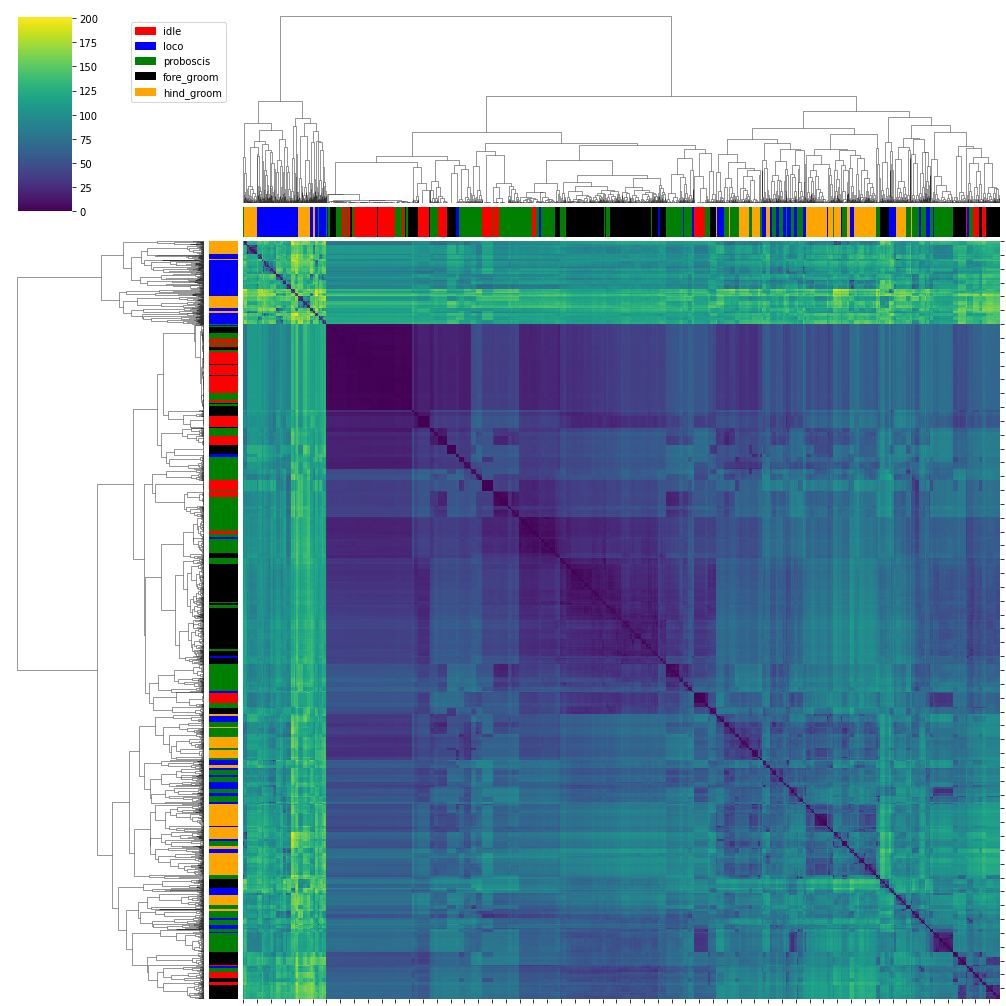

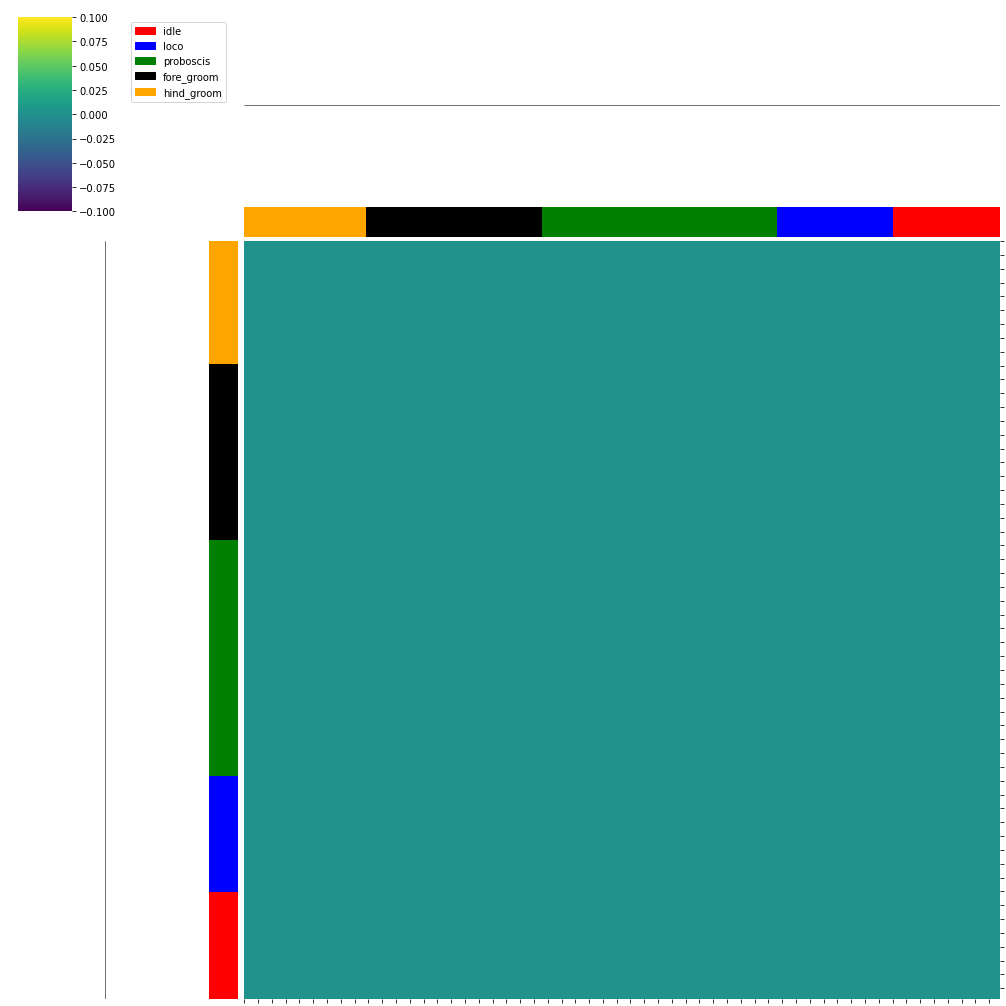

In [25]:
input = np.abs(all_wavelets)**2
for dist_metric in ['cityblock','euclidean']: # , 'kullback-leibler', 'jensen-shannon']:
    thresholded_input = threshold_power_spectra(input, 1e7)
    normalized_thresholded_input,node_means,node_stds = normalize_power_spectra(thresholded_input)
    logger.info(f"Computing distance matrix using {dist_metric} distance")
    distance_matrix = compute_distance_matrix(normalized_thresholded_input, dist_metric) 
    plot_clustermap(distance_matrix, behavior_labels, f'figures/power_clustermap_tieredls_normalization_threshold1e7_{dist_metric}.jpg')


In [ ]:
thresholded_input.shape